# Comparing what we find in their processed data and ours

In [1]:
geo = 'GSE71585'
import scanpy as sc
import pandas as pd
import numpy as np
from anndata import AnnData
import matplotlib.pyplot as plt
%matplotlib inline

root_dir = '/cellar/users/hsher/Data/ideker/sc/pickle/'
data_id = pd.read_excel('../data/RNA-seq.xlsx')

metadata = pd.read_csv('../data/GSE71585_metadata.csv', header = 0)
metadata.set_index('title', inplace = True)

# make into count matrix
df = pd.read_pickle(root_dir + geo +'.pickle') # human single cell data with 141 neuron and 16 microglia (should be)

obs = metadata
processed = AnnData(X = df.transpose())
processed.obs = obs
processed

y_label = metadata.loc[processed.obs.index, 'cell type']

# binarize y
class_y = []


non_neuron = ['Endo', 'Astro', 'Oligo', 'OPC', 'Micro']
gaba = ['Ndnf', 'Vip', 'Sst', 'Pvalb', 'Sncg', 'Igtp','Cd34']
gluta = ['Ngb', 'Mgp', 'Scnn1a', 'Batf3','Hsd11b1', 'Arf5', 'Cdh13', 'L2', 'L3', 'L4', 'L5', 'L6']
for y in y_label:
    celltype = 'unclassified'
    for name in non_neuron:
        if name in y:
            celltype = 'non-neuronal'
            
    for name in gaba:
        if name in y:
            celltype = 'GABA'
            break # 0 = non-neuron
    for name in gluta:
        if name in y:
            celltype = 'glutaminergic'
            break #1 = neuron
    class_y.append(celltype)
processed.obs['class'] = class_y

/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
processed.obs.loc[processed.obs['class'] == 'unclassified']['cell type'].unique()

array([' N/A', ' Y', ' N'], dtype=object)

In [3]:
finer_class = []
for x in processed.obs['cell type']:
    fit = [i for i in ['Endo', 'Astro', 'OPC','Oligo','Micro','Ndnf','Igtp','Sncg','Cd34','Vip', 'Sst', 'Pvalb','L2', 'L3', 'L4', 'L5', 'L6'] if i in x]
    if len(fit) == 0:
        finer_class.append('')
        #print(x, fit)
    elif len(fit) == 1:
        finer_class.append(fit[0])
    else:
        finer_class.append(fit[0]+'-'+fit[1])
processed.obs['finer_class'] = finer_class

[data description](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE73721)
[Brain RNA-seq](http://www.brainrnaseq.org/)


[FPKM](https://statquest.org/2015/07/09/rpkm-fpkm-and-tpm-clearly-explained/)

## read processed data into AnnData

# Quality comparison

In [4]:
def quality(adata):
    
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1)
    
    mito_genes = adata.var_names.str.startswith('mt-')
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1)/ np.sum(adata.X, axis=1)
    
    adata.obs['n_genes'] = np.sum(adata.X > 0, axis = 1)
    
    # per gene
    adata.var['n_counts'] = adata.X.sum(axis=0)
    
    # per gene
    adata.var['n_cell'] = np.sum(adata.X > 0, axis = 0)

In [5]:
quality(processed)


... storing 'tissue' as categorical
... storing 'cell type' as categorical
... storing 'class' as categorical
... storing 'finer_class' as categorical


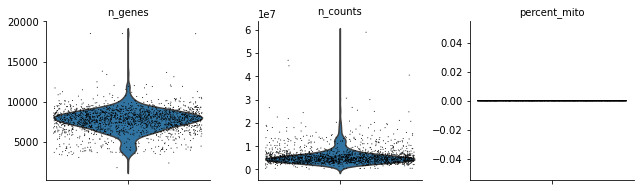

In [6]:
sc.pl.violin(processed, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)


In [7]:
def previs(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed = True)
    sc.pp.log1p(adata) # FPKM is not logged
        
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    
    sc.tl.pca(adata, n_comps = 20)
def umap(adata, n_pcs = 20):
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=npcs)
    sc.tl.umap(adata)

In [8]:
previs(processed)

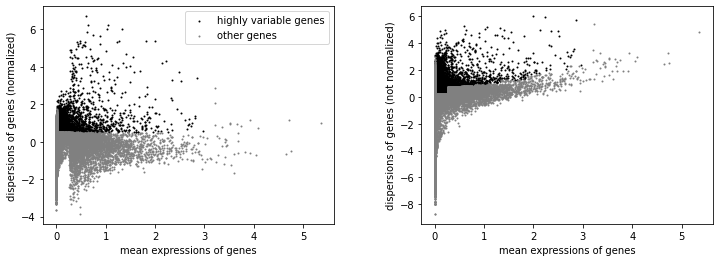

In [9]:
sc.pl.highly_variable_genes(processed)

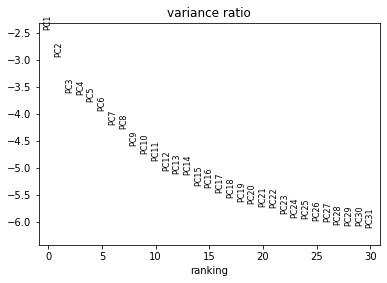

In [10]:
sc.tl.pca(processed)
sc.pl.pca_variance_ratio(processed, log=True)


/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


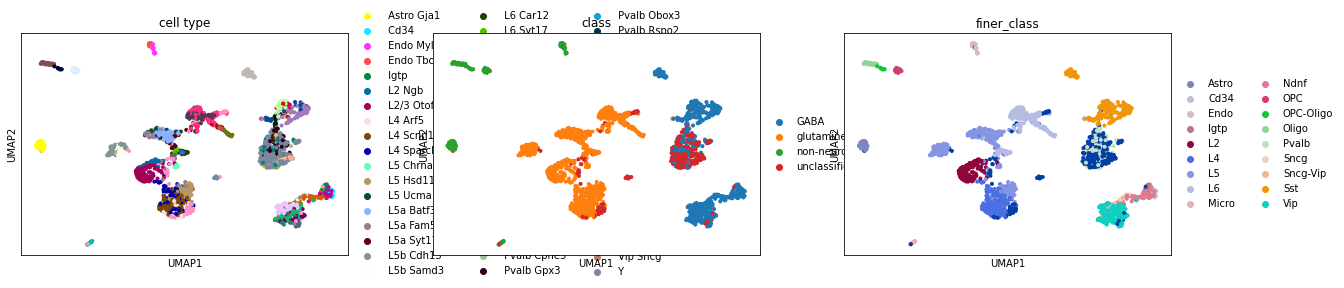

In [11]:
sc.pp.neighbors(processed, n_neighbors=10, n_pcs=10)
sc.tl.umap(processed)
sc.pl.umap(processed, color = ['cell type', 'class', 'finer_class'])


In [12]:
homolog_mapper = pd.read_csv('human_mouse_homolog', sep = '\t', header = None)[[0,4]]

In [13]:
homolog_mapper.columns = ['human', 'mouse']

In [14]:
homolog_mapper = homolog_mapper.drop_duplicates(subset = ['mouse']).drop_duplicates(subset = ['human']).set_index('mouse')

In [15]:
homolog_mapper

,human
mouse,
A1bg,A1BG
A1cf,A1CF
A2m,A2M
A3galt2,A3GALT2
A4galt,A4GALT
...,...
Zyg11a,ZYG11A
Zyg11b,ZYG11B
Zyx,ZYX


In [16]:
mapped = processed[:, processed.var.index.isin(homolog_mapper.index)]
mapped.var.index = mapped.var.index.map(homolog_mapper['human'])

/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


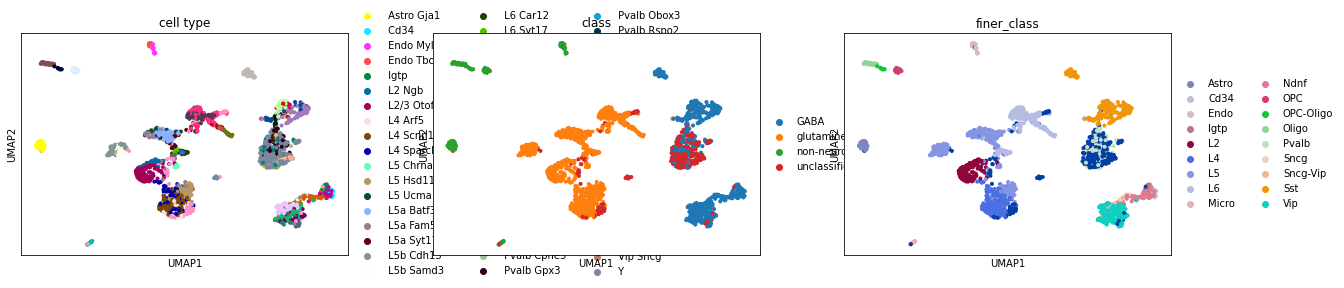

In [22]:
sc.pp.neighbors(mapped, n_neighbors=10, n_pcs=10)
sc.tl.umap(mapped)
sc.pl.umap(mapped, color = ['cell type', 'class', 'finer_class'])


In [23]:
mapped.write('tasic.h5ad')

# differentially expressed genes for GABA and glutaminergic

In [17]:
sc.tl.rank_genes_groups(processed, groupby = 'class', groups = ['GABA', 'glutaminergic'], n_genes = 1000)

In [18]:
gaba_genes = [pair[0] for pair in processed.uns['rank_genes_groups']['names']]
gluta_genes = [pair[1] for pair in processed.uns['rank_genes_groups']['names']]

In [19]:
de_gene_df = pd.DataFrame(np.array([gaba_genes + gluta_genes, ['GABA']*1000 + ['gluta']*1000]).T, columns = ['gene', 'Celltype'])


In [20]:
de_gene_df

,gene,Celltype
0,Gad1,GABA
1,Gad2,GABA
2,Zcchc12,GABA
3,Slc6a1,GABA
4,Inpp5f,GABA
...,...,...
1995,Klf7,gluta
1996,Trib1,gluta
1997,Dab1,gluta
1998,Slit3,gluta


In [21]:
de_gene_df.to_excel('/cellar/users/hsher/ontoPrune/notebook/GABA_gluta.xlsx')